In [13]:
import numpy as np
import cmdstanpy
import matplotlib.pyplot as plt

def simulate_regions(n_timesteps: int, n_regions: int) -> np.ndarray:
    rng = np.random.RandomState(0)
    time = np.arange(n_timesteps)
    rfx_int = rng.normal(loc=0, scale=0.25, size=n_regions)
    rfx_slope = rng.normal(loc=0, scale=0.2, size=n_regions)

    expectation = np.exp(
        (0.5 + rfx_slope) * np.sin(2 * np.pi * time.reshape(-1, 1) / 7) + 2.5 + rfx_int
    )

    return expectation


def create_counterfactuals(expectation: np.ndarray, lift=1.1) -> np.ndarray:
    n_timesteps, n_regions = expectation.shape
    rng = np.random.RandomState(0)

    noise = rng.multivariate_normal(
        mean=np.zeros(n_regions), cov=3.0*np.eye(n_regions), size=(2, n_timesteps)
    )

    Y0 = expectation + noise[0]
    Y1 = lift * expectation + noise[1]

    return Y0, Y1


def create_geo_data(Y0: np.ndarray, Y1: np.ndarray, treat_time: int = 60, n_treated=9):
    n_timesteps, n_regions = Y0.shape

    treated_times = np.arange(n_timesteps) >= treat_time
    treated_regions = np.arange(n_regions) < n_treated

    yc0 = Y0[np.ix_(~treated_times, ~treated_regions)]
    yc1 = Y0[np.ix_(treated_times, ~treated_regions)]
    yt0 = Y0[np.ix_(~treated_times, treated_regions)]
    yt1 = Y1[np.ix_(treated_times, treated_regions)]
    return (yc0, yc1, yt0, yt1)



expectation = simulate_regions(n_timesteps=120, n_regions=50)

Y0, Y1 = create_counterfactuals(expectation)

yc0, yc1, yt0, yt1 = create_geo_data(Y0, Y1)

stan_data = dict(
    n_timesteps_pre=len(yc0),
    n_timesteps_post=len(yc1),
    n_control_regions=yc1.shape[1],
    n_treatment_regions=yt0.shape[1],
    y_control_pre=yc0,
    y_control_post=yc1,
    y_treatment_pre=yt0,
    y_treatment_post=yt1,
    sample=1,
    sum_to_one_constraint=1
)



In [14]:
model = cmdstanpy.CmdStanModel(stan_file="geo_model.stan")
fit = model.sample(data=stan_data)
print(fit.diagnose())

13:49:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:50:01 - cmdstanpy - INFO - CmdStan done processing.
13:50:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'geo_model.stan', line 92, column 12 to column 128)
Consider re-running with show_console=True if the above output is unclear!



Processing csv files: /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmplor7sngi/geo_modelopqq8rku/geo_model-20241110134958_1.csv, /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmplor7sngi/geo_modelopqq8rku/geo_model-20241110134958_2.csv, /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmplor7sngi/geo_modelopqq8rku/geo_model-20241110134958_3.csv, /var/folders/tz/6cbs4vm91539frf3vzvqjmcr0000gn/T/tmplor7sngi/geo_modelopqq8rku/geo_model-20241110134958_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [15]:
draws = fit.stan_variables()

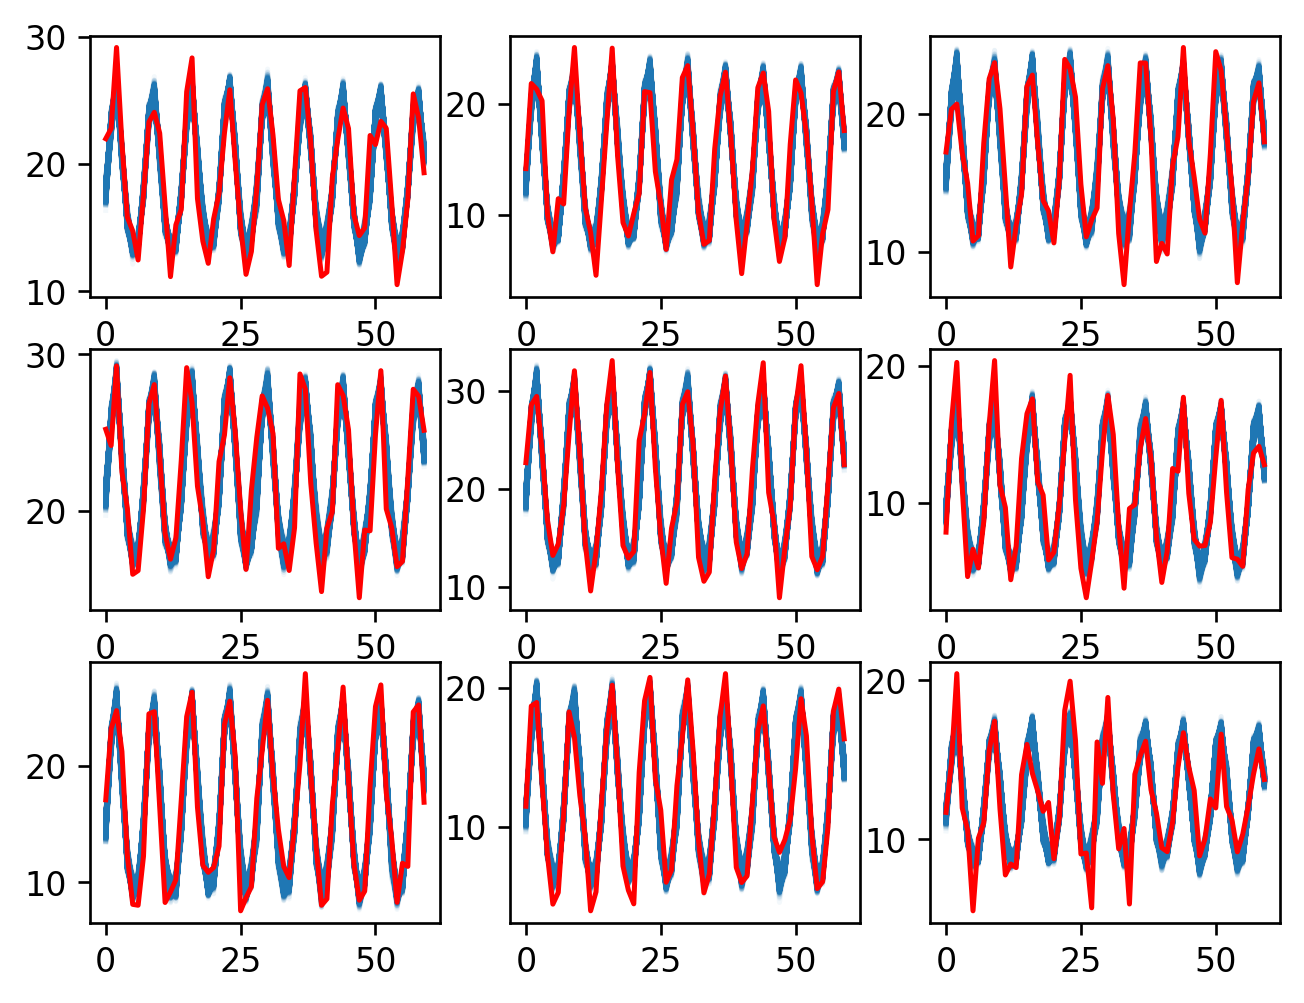

In [16]:
fig, ax = plt.subplots(dpi= 240, ncols=3, nrows=3)
ax = ax.ravel()

for i,a in enumerate(ax):

    a.plot(draws['insample_fit'][:, :, i].T, color='C0', alpha=0.05)
    a.plot(yt0[:, i], color='red')